In [ ]:
pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import torch
import transformers  as ppb 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.engine import Layer
from keras.layers import Activation, Add, Bidirectional, Conv1D, Dense, Dropout, Embedding, Flatten
from keras.layers import concatenate, GRU, Input, LSTM, MaxPooling1D
from keras.layers import GlobalAveragePooling1D,  GlobalMaxPooling1D, SpatialDropout1D
from keras.models import Model
import keras.backend as k
from keras.optimizers import Adam
from keras.preprocessing import text, sequence
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.test.utils import common_texts, get_tmpfile
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import *
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from smart_open import smart_open
import datetime 
from keras.utils import multi_gpu_model

import os
import time
import gc
import re
import random

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

#We can use BERT but here I am using DistillBERT because BERT requires more RAM then available in the colab,but to use BERT just uncomment the next line and comment the previous line
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
#To run the model on GPU
#model.cuda()   

In [ ]:
gru_len = 128
Routings = 5
Num_capsule = 10
Dim_capsule = 16
dropout_p = 0.3
rate_drop_dense = 0.3

In [ ]:
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x


# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)


# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)


class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)


In [ ]:
#Importing the dataset
import pandas as pd
 
dataset=pd.read_csv('/content/1000_tweets_2_user_new_non-bot.csv')
#dataset.iloc[:,0:1].fillna('other', inplace=True)
y=dataset.iloc[:,1].values

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
k=0
X_train=[]
y_train=[]
for i in range(0,2):
  for j in range(k,k+980):
    X_train.append(dataset.iloc[j,0])
    y_train.append(dataset.iloc[j,1])
  k+=1000

In [ ]:
for i in range(0,980):
  X_train.append(dataset2.iloc[i,2])
  y_train.append(112345)

In [ ]:
for i in range(980,1000):
  X_test.append(dataset2.iloc[i,2])
  y_test.append(112345)

In [ ]:
k=980
X_test=[]
y_test=[]
for i in range(0,2):
  for j in range(k,k+20):
    X_test.append(dataset.iloc[j,0])
    y_test.append(dataset.iloc[j,1])
  k+=1000

In [ ]:
X_train

["b'To the lady with free punching bag (Any): Hi  To the lady with the punching bag. Your contact information is undeli... http://bit.ly/5FRzsG\\n'",
 "b'free lateral file cabinet: the email does not work and I would like to gett it thanks http://bit.ly/6bMXxa http://bit.ly/6KPOg2\\n'",
 "b'Give out some Free toothbrush: I got a bunch of extra toothbrushes at home which I never touch because I use el.. http://bit.ly/3XT9vW\\n'",
 'b"Wood Pallets (45 & West Road): 4 ft x 10 ft wood pallets they have 10 ft long 4x4\'s on them and 4 ft 1x6\'s... http://bit.ly/zptAY\\n"',
 "b'Free Clothes and purses (cleveland): Free clothes little girls, women, and men plus some purses and shoes....must t... http://bit.ly/5Aqgie\\n'",
 "b'curb alert-chest FREEZER-works! (Steeplechase 77065): On the curb at 10414 Jockey Club Drive Houston, Tx. 77065 (en... http://bit.ly/7VSIAz\\n'",
 "b'male pit $30 re-homing fee 832-435-6554 (aldine): 14 mo. old male rednose http://bit.ly/8Eaj2t http://bit.ly/6KPOg2\\n'",

In [ ]:
X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)
y_train=pd.DataFrame(y_train)
y_test=pd.DataFrame(y_test)
X_train=X_train.iloc[:,:].values
X_test=X_test.iloc[:,:].values
y_train=y_train.iloc[:,:].values
y_test=y_test.iloc[:,:].values

In [ ]:
train=np.concatenate((X_train,y_train),axis=1)
test=np.concatenate((X_test,y_test),axis=1)

In [ ]:
np.random.shuffle(train)
np.random.shuffle(test)

In [ ]:
train=pd.DataFrame(train)
test=pd.DataFrame(test)

In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
  sentence=str(sentence)
  sentence = sentence.lower()
  return sentence
  '''
  sentence=sentence.replace('{html}',"") 
  cleanr = re.compile('<.*?>#@')
  cleantext = re.sub(cleanr, '', sentence)
  rem_url=re.sub(r'http\S+', '',cleantext)
  rem_num = re.sub('[0-9]+', '', rem_url)
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(rem_num)  
  filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
  stem_words=[stemmer.stem(w) for w in filtered_words]
  lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
  return " ".join(filtered_words)
'''

train.iloc[:,0]=train.iloc[:,0].map(lambda s:preprocess(s))
test.iloc[:,0]=test.iloc[:,0].map(lambda s:preprocess(s))

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = list((stopwords.words('english')))

def text_prepare(text,join_sumbol):
    """
        text: a string
        
        return: modified initial string
    """
    # lowercase text
    text = text.lower() 

    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(REPLACE_BY_SPACE_RE," ",text,)

    # delete symbols which are in BAD_SYMBOLS_RE from text
    text = re.sub(BAD_SYMBOLS_RE,"",text)
    text = re.sub(r'\s+'," ",text)

    # delete stopwords from text
    text = f'{join_sumbol}'.join([i for i in text.split() if i not in STOPWORDS])
    
    return text

In [ ]:
l=preprocess(train.iloc[0,0])


In [ ]:
print(train.iloc[0,0])
print(l)

b'Now playing: Mr. President - 4 On The Floor. Tune in: http://stream.laut.fm/eurodance.m3u\n'
playing president floor tune


In [ ]:
X_train=train.iloc[:,0]
X_test=test.iloc[:,0]
y_train=train.iloc[:,1]
y_test=test.iloc[:,1]

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
y_train = np_utils.to_categorical(encoded_Y)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
y_test = np_utils.to_categorical(encoded_Y)

In [ ]:
y_test.shape

(40, 2)

In [ ]:
X_train=pd.DataFrame(X_train)

In [ ]:

X_train

,0
0,b'a tribute to #switzerland http://ow.ly/1gpe...
1,"b'haridwar in india, call ""the getaway to god ..."
2,b'working ge commercial dryer (woodlands/conro...
3,b'#prambanan ?the most amazing collection of m...
4,b'#batalha monastery it is one of the best and...
...,...
1955,b'beige mircofiber couch (northside): i have a...
1956,"b'tips for those traveling to san francisco, c..."
1957,"b'm?laga fair, probably the biggest party of t..."
1958,"b'free kitten (baytown tx): 11 weeks old, blac..."


In [ ]:

tokenized = X_train.apply((lambda x: tokenizer.encode(str(X_train[0]), add_special_tokens=True)))

In [ ]:
tokenized = X_train.iloc[:,0].apply((lambda x: tokenizer.encode(str(x), add_special_tokens=True)))

In [ ]:

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
#for adding paddings
input_ids = torch.tensor(np.array(padded))


In [ ]:
#to set the paddings to zero and rest to 1
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(1960, 77)

In [ ]:
input_ids = (torch.tensor(padded))
attention_mask = (torch.tensor(attention_mask))

In [ ]:
with torch.no_grad():
    last_hidden_states_train= model(input_ids,attention_mask)
    

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_eval, y_train, y_eval = train_test_split(last_hidden_states_train[0],y_train, test_size = 0.25, random_state = 0)

In [ ]:
 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers import AveragePooling1D
from keras.layers import Flatten
from keras.layers import Dense


In [ ]:
def model2(filter_kernels, dense_outputs, maxlen, vocab_size, nb_filter,cat_output):                                                  # For Character Embedding use this model instead of above model
    d = 300                                                             #Embedding Size
    Embedding_layer  = Embedding(vocab_size+1, d, input_length=maxlen)
    inputs = Input(shape=(maxlen,), name='input', dtype='float32')
    embed = Embedding_layer(inputs)
    z = Dropout(0.25)(Dense(dense_outputs, activation='relu')(embed))
    conv = Convolution1D(nb_filter=nb_filter, filter_length=filter_kernels[0],
                             border_mode='valid', activation='relu',
                             input_shape=(maxlen, d))(z)
    conv = MaxPooling1D(pool_length=3)(conv)

    conv1 = Convolution1D(nb_filter=nb_filter, filter_length=filter_kernels[1],
                          border_mode='valid', activation='relu')(conv)
    conv1 = MaxPooling1D(pool_length=3)(conv1)

    conv2 = Convolution1D(nb_filter=nb_filter, filter_length=filter_kernels[2],
                          border_mode='valid', activation='relu')(conv1)
    conv5 = MaxPooling1D(pool_length=3)(conv2)
    conv6= Capsule(num_capsule=1 ,dim_capsule=72, routings=1,share_weights=True)(conv5)
    conv = Flatten()(conv6)

    #Two dense layers with dropout of .5
    #z = Dropout(0.5)(Dense(dense_outputs, activation='relu')(conv))
    # z = Dropout(0.5)(Dense(dense_outputs, activation='relu')(z))

    pred = Dense(cat_output, activation='softmax', name='output')(conv)

    model = Model(input=inputs, output=pred)

    #sgd = SGD(lr=0.001, momentum=0.9)
    #model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    return model

In [ ]:
classifier = Sequential()
classifier.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(77,768)))
#classifier.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#classifier.add(Dropout(0.5))
#classifier.add(AveragePooling1D(3))
#classifier.add(Bidirectional(GRU(64, activation='sigmoid', dropout=dropout_p, recurrent_dropout=dropout_p, return_sequences=True)))
classifier.add(Capsule(num_capsule=1 ,dim_capsule=72, routings=1,share_weights=True))
#classifier.add(Reshape(-1,100))
classifier.add(Flatten())
#classifier.add(Dense(100, activation='relu'))
classifier.add(Dense(2, activation='softmax'))
classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 75, 64)            147520    
_________________________________________________________________
capsule_1 (Capsule)          (None, 1, 72)             4608      
_________________________________________________________________
flatten_1 (Flatten)          (None, 72)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 146       
Total params: 152,274
Trainable params: 152,274
Non-trainable params: 0
_________________________________________________________________


In [ ]:
classifier.fit(np.array(X_train),np.array(y_train),batch_size=128,epochs=30,validation_data=(np.array(X_eval),np.array(y_eval)),verbose=1,callbacks=[es])

Train on 1470 samples, validate on 490 samples
Epoch 1/30
1470/1470 [==============================] - 3s 2ms/step - loss: 0.4551 - accuracy: 0.8401 - val_loss: 0.2276 - val_accuracy: 0.9857
Epoch 2/30
1470/1470 [==============================] - 2s 2ms/step - loss: 0.1675 - accuracy: 0.9946 - val_loss: 0.1301 - val_accuracy: 0.9939
Epoch 3/30
1470/1470 [==============================] - 2s 2ms/step - loss: 0.1085 - accuracy: 0.9952 - val_loss: 0.0967 - val_accuracy: 0.9959
Epoch 4/30
1470/1470 [==============================] - 2s 2ms/step - loss: 0.0832 - accuracy: 0.9980 - val_loss: 0.0824 - val_accuracy: 0.9939
Epoch 5/30
1470/1470 [==============================] - 2s 2ms/step - loss: 0.0687 - accuracy: 0.9980 - val_loss: 0.0717 - val_accuracy: 0.9939
Epoch 6/30
1470/1470 [==============================] - 2s 2ms/step - loss: 0.0590 - accuracy: 0.9980 - val_loss: 0.0642 - val_accuracy: 0.9959
Epoch 7/30
1470/1470 [==============================] - 2s 2ms/step - loss: 0.0519 - accu

In [ ]:
X_test=pd.DataFrame(X_test)
tokenized = X_test.iloc[:,0].apply((lambda x: tokenizer.encode(str(x), add_special_tokens=True)))

In [ ]:

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(77-len(i)) for i in tokenized.values])

In [ ]:
#for adding paddings
input_ids = torch.tensor(np.array(padded))

In [ ]:
#for adding paddings
input_ids = torch.tensor(np.array(padded))

In [ ]:
#to set the paddings to zero and rest to 1
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(40, 77)

In [ ]:
input_ids = (torch.tensor(padded))
attention_mask = (torch.tensor(attention_mask))

In [ ]:
with torch.no_grad():
    last_hidden_states_test = model(input_ids,attention_mask)

In [ ]:
y_pred =  classifier.predict(last_hidden_states_test[0])

In [ ]:
last_hidden_states_test[0].shape

torch.Size([40, 77, 768])

In [ ]:

y_pred.shape

(40, 2)

In [ ]:
X_test.shape

(40, 1)

In [ ]:

#TO get maximum value as 1 and rest to zero
y_pred=pd.DataFrame(y_pred)
y_pred=y_pred.eq(y_pred.where(y_pred != 0).max(1), axis=0).astype(int)
y_pred=y_pred.iloc[:,:].values

In [ ]:
y_test=pd.DataFrame(y_test)
y_test=y_test.eq(y_test.where(y_test != 0).max(1), axis=0).astype(int)
y_test=y_test.iloc[:,:].values

In [ ]:

result=[]
for i in range(0,len(y_test)):
  for j in range(0,len(y_test[0])):
    if(y_test[i][j]==1):
      result.append(j)


In [ ]:
predicted=[]
for i in range(0,len(y_pred)):
  for j in range(0,len(y_pred[0])):
    if(y_pred[i][j]==1):
      predicted.append(j)



In [ ]:


print(result)
print(predicted)

[0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1]
[0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1]


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(result,predicted)

cm

array([[20,  0],
       [ 0, 20]])

In [ ]:

from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
print('Confusion Matrix :')
print(cm) 
print('Accuracy Score :',accuracy_score(result, predicted)) 
print('Report : ')
print(classification_report(result, predicted)) 


Confusion Matrix :
[[20  0]
 [ 0 20]]
Accuracy Score : 1.0
Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [ ]:
class_idx = np.argmax(y_pred[0])

In [ ]:
class_output = classifier.output[:, class_idx]

In [ ]:
class_output.shape

TensorShape([None])

In [ ]:
X_train

,0
0,swear bout platinum new hot song shoe strings ...
1,darrenbeast nigga
2,bmrbauty feelin like back sleep ill night
3,see something walk like wait minute see
4,nagasaki remembered usc gathering
...,...
2245,please check new cover taylor swift fearless o...
2246,boop alert one veiny cock
2247,gone younger speaker clearly appeal teenage girls
2248,ashwinpande watched last night still love


In [ ]:
tokenizer = Tokenizer(num_words=4000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = 40
embedding_dim = 50
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)


NameError: ignored

In [ ]:
sequence_input = layers.Input(shape=(maxlen,), dtype='tf.float32')
embedded_sequences = layers.Embedding(vocab_size, embedding_dim, input_length=maxlen)(sequence_input)
l_cov1  = layers.Conv1D(317, 3, activation='relu')(embedded_sequences)
l_pool1 = layers.MaxPooling1D(2)(l_cov1)
l_cov2  = layers.Conv1D(317, 1, activation='relu')(l_pool1)
l_cov3  = layers.Conv1D(317, 2, activation='relu')(l_cov2)
l_pool3 = layers.GlobalMaxPooling1D()(l_cov3)  # global max pooling
l_bnorm = layers.BatchNormalization()(l_pool3)
l_dense = layers.Dense(128, activation='relu')(l_pool3)
preds   = layers.Dense(50, activation='sigmoid',name='preds')(l_dense)
model = Model(sequence_input, outputs=preds)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
model.fit(X_train, y_train, epochs=3, validation_split=0.1, batch_size=10)

TypeError: ignored

In [ ]:
y_pred=model.predict(X_test)

ValueError: ignored

In [ ]:
X_test

["b'@FlocoTorres I will sir. Have you seen it? Sorry about the angle... I was in the back wit the cam above my head & my gf in my arms\\n'",
 'b"Heard the first few tracks of Gucci & @DjDrama \'s Burrprint 3-D... BURR!\\n"',
 "b'@elise5000 No problemo. I love the promotion of good product.\\n'",
 'b"My brain races miles ahead of what I\'m sayin sometimes. Its the only time I ever stutter. Don\'t mistake it for nervousness.\\n"',
 "b'Props to @ALKINGyouworms to being patient while @beat_geeks perfects their craft!\\n'",
 "b'DeMint escalates attacks on Obama plan http://bit.ly/Uired\\n'",
 'b"Court\'s ruling protects S.C. wetlands; conservationists applaud long-awaited decision. http://bit.ly/do78qg\\n"',
 "b'Columbia city lawyer recommends delaying election to replace councilman Cromartie: http://bit.ly/daqDBN\\n'",
 "b'Did you snap pics at Swansea chemical spill? Send to online@thestate.com and thanks. Also, just updated story: http://bit.ly/bi84Z\\n'",
 "b'Tuesday | First USC practice

In [ ]:
class_idx = np.argmax(y_train[0]) #not needed in this case as only two classes
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("conv1d_12")

In [ ]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate(["Xtst"])

TypeError: ignored

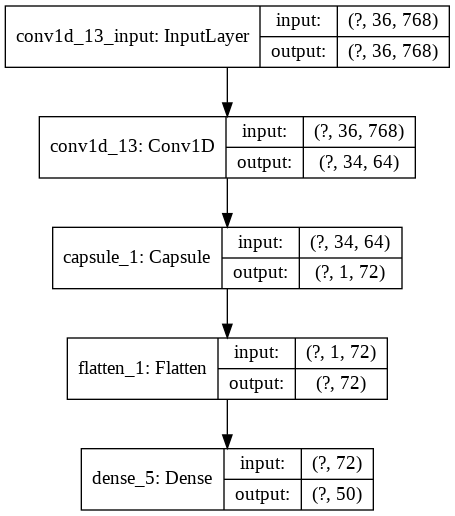

In [ ]:
tf.keras.utils.plot_model(
    classifier,
    to_file="classifier1.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [ ]:
import matplotlib.pyplot as plt
top_layer = classifier.layers[1]
plt.imshow(top_layer.get_weights()[0][:, :, 0].squeeze(), cmap='gray')

ValueError: ignored

TypeError: ignored

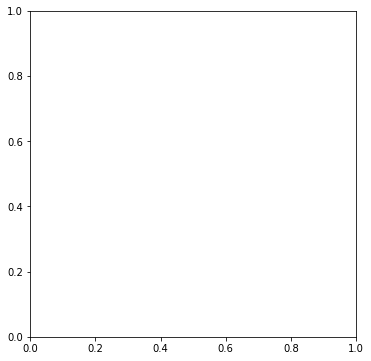

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

plt.imshow(X_train[0])

In [ ]:
import tensorflow as tf 
v = tf.Variable([[1, 2], [3, 4]])   
tf.keras.constraints.UnitNorm(axis=1)(tf.cast(pooled_grads, tf.float32))

ValueError: ignored

In [ ]:
X_train

,0
0,swear bout platinum new hot song shoe strings ...
1,darrenbeast nigga
2,bmrbauty feelin like back sleep ill night
3,see something walk like wait minute see
4,nagasaki remembered usc gathering
...,...
2245,please check new cover taylor swift fearless o...
2246,boop alert one veiny cock
2247,gone younger speaker clearly appeal teenage girls
2248,ashwinpande watched last night still love


In [ ]:
def plot_saliency(loaded_model, pure_txt, text_class, pred_labels, text_sequence):
    text_class = 'Positive' if text_class==1 else 'Negative'
    pred_labels = 'Positive' if pred_labels==1 else 'Negative'

    input_tensors = [loaded_model.input, K.learning_phase()]
    model_input = loaded_model.layers[2].input # the input for convolution layer
    model_output = loaded_model.output[0][1]
    gradients = loaded_model.optimizer.get_gradients(model_output,model_input)
    compute_gradients = K.function(inputs=input_tensors, outputs=gradients)
    matrix = compute_gradients([text_sequence.reshape(1,30), text_class])[0][0]
    matrix = matrix[:len(pure_txt),:]

    matrix_magnify=np.zeros((matrix.shape[0]*10,matrix.shape[1]))
    for i in range(matrix.shape[0]):
        for j in range(10):
            matrix_magnify[i*10+j,:]=matrix[i,:]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.imshow(normalize_array(np.absolute(matrix_magnify)), interpolation='nearest', cmap=plt.cm.Blues)
    plt.yticks(np.arange(5, matrix.shape[0]*10, 10), pure_txt, weight='bold',fontsize=24)
    plt.xticks(np.arange(0, matrix.shape[1], 50), weight='bold',fontsize=24)
    plt.title('True Label: "{}" Predicted Label: "{}"'.format(text_class,pred_labels), weight='bold',fontsize=24)
    plt.colorbar()
    plt.show()

In [ ]:
input_tensors = [model.input, K.learning_phase()]
model_input = model.layers[2].input

In [ ]:
 model_output = model.output[0][1]

In [ ]:
gradients = model.optimizer.get_gradients(model_output,model_input)

In [ ]:
compute_gradients = K.function(inputs=input_tensors, outputs=gradients)

In [ ]:
matrix = compute_gradients([text_sequence.reshape(1,30), 'positive'])[0][0]

NameError: ignored

In [ ]:
k=980
X_train1=[]
y_train1=[]
for i in range(0,2):
  for j in range(k,k+20):
    X_train1.append(dataset.iloc[j,0])
    y_train1.append(dataset.iloc[j,1])
  k+=1000

In [ ]:
for i in range(1000,1050):
  X_train1.append(dataset2.iloc[i,2])
  y_train1.append(112345)

In [ ]:

file=open("heatmap_capsules_for_users.html","w")
for i in range(0,20):
  type_here=[]
  type_here.append(X_train1[i])
  typr_here=pd.DataFrame(type_here)
  typr_here.iloc[:,0]=typr_here.iloc[:,0].map(lambda s:preprocess(s))
  tokenized = typr_here.iloc[:,0].apply((lambda x: tokenizer.encode(str(x), add_special_tokens=True)))
  padded = np.array([i + [0]*(77-len(i)) for i in tokenized.values])
  input_ids = torch.tensor(np.array(padded))
  attention_mask = np.where(padded != 0, 1, 0)
  input_ids = (torch.tensor(padded))
  attention_mask = (torch.tensor(attention_mask))
  with torch.no_grad():
    last_hidden_states_test = model(input_ids,attention_mask)
  y_pred = classifier.predict(last_hidden_states_test[0])
  Xtst=last_hidden_states_test[0]
  class_idx = np.argmax(y_pred[0]) #not needed in this case as only two classes
  class_output = classifier.output[:, class_idx]
  last_conv_layer = classifier.get_layer("conv1d_1")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads)
  iterate = K.function([classifier.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([Xtst])
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap,0)
  heatmap /= np.max(heatmap)#normalise values in the prediction
  norm_len = 36/last_conv_layer.output_shape[1]
  html = ""
  if y_pred[0][0]>0.5:
    pred = '90078731'
  else:
    pred = '51964081'
  html += "<span><h3>Based on the description, the model believes that text belongs to {} author ".format(pred)
  html += "<small><br>Confidence: {:.0f}%<br><br></small></h3></span>".format(abs(((y_pred[0][0]*100)-50)*2))
  for j,i in enumerate((type_here[0].lower()).split()):
    html += "<span style='background-color:rgba({},0,15,{})'>{} </span>".format(heatmap[math.floor(j/norm_len)]*255,heatmap[math.floor(j/norm_len)]-0.3,i)
  file.write(html)
file.close()   





In [ ]:
 y_pred = classifier.predict(last_hidden_states_test[0])


In [ ]:
Xtst=last_hidden_states_test[0]

In [ ]:
class_idx = np.argmax(y_pred[0]) #not needed in this case as only two classes
class_output = classifier.output[:, class_idx]
last_conv_layer = classifier.get_layer("conv1d_7")

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import HTML
from sklearn.model_selection import train_test_split
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
from keras.models import Model
from keras import backend as K 
from keras.models import Sequential
from keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer


pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [ ]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads)
iterate = K.function([classifier.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([Xtst])

In [ ]:


heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)#normalise values in the prediction


In [ ]:


norm_len = 36/last_conv_layer.output_shape[1] # fi

In [ ]:
html = ""
if y_pred[0]>0.5:
  pred = '90078731'
else:
  pred = '15401533'
html += "<span><h3>Based on the description, the model believes that text belongs to {} author ".format(pred)
html += "<small><br>Confidence: {:.0f}%<br><br></small></h3></span>".format(abs(((y_pred[0][0]*100)-50)*2))
for j,i in enumerate(type_here[0].split()):
  html += "<span style='background-color:rgba({},0,150,{})'>{} </span>".format(heatmap[math.floor(j/norm_len)]*255,heatmap[math.floor(j/norm_len)]-0.3,i)

HTML(html)


In [ ]:
dataset

,0,1
0,"b'The time in Hollywood, CA, is 11:16:13 pm\n'",51964081
1,"b'The time in #Hollywood, #CA, is 6:15:23 am\n'",51964081
2,"b'The time in Hollywood, CA, is 8:20:01 am\n'",51964081
3,"b'The time in #Hollywood, #CA, is 5:24:29 am\n'",51964081
4,"b'The time in Hollywood, CA, is 1:56:29 pm\n'",51964081
...,...,...
1995,b'Now playing: Mario Lopez - Alone. Tune in: http://stream.laut.fm/eurodance.m3u\n',90078731
1996,b'Now playing: Axel Coon - Close to You. Tune in: http://stream.laut.fm/eurodance.m3u\n',90078731
1997,b'Now playing: Sash! - I Believe. Tune in: http://stream.laut.fm/eurodance.m3u\n',90078731
1998,b'Now playing: Lou Sern - Swiss Boy. Tune in: http://stream.laut.fm/eurodance.m3u\n',90078731


In [ ]:
type_here=["MKSDKSJDKCJNNCNKNCKNWSKXKSssssssskwjkdsdd"]
typr_here=pd.DataFrame(type_here)

In [ ]:

typr_here.iloc[:,0]=typr_here.iloc[:,0].map(lambda s:preprocess(s))

In [ ]:
typr_here

,0
0,mksdksjdkcjnncnkncknwskxksssssssskwjkdsdd
